In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.velocity_transformations import equatorial_UVW
from modules.vr_opt import VrOpt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import normalized_mutual_info_score
import hdbscan
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph, sort_graph_by_row_values

from Distant_SigMA.SigMA.SigMA import SigMA
from scipy.stats import norm
from math import ceil
from scipy.stats import gaussian_kde
from sklearn.metrics.cluster import normalized_mutual_info_score

# Generate mock data

In [137]:
# Plotting related stuff
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:grey']
zorders = [2, 2, 2, 2, 2, 1]
alphas = [0.9, 0.9, 0.9, 0.9, 0.9, 0.3]
log = True

In [138]:
# Create 6D Gaussian data
n = 1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50 #background dataset of random points uniformly distributed 6D

mu = np.array([-5, 5, 5, 5, -5, 5]) #first 3 for average position of the Cluster in 3D(XYZ). Last 3 for average velocities in (VxVyVz)
c_xx = c_yy = 20 #Variance of the average in x and y.
c_xy = 15 # correlation of x and y, positive -> there is a correlation 
c_zz = 3 #Variance in z 
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy #makes positive correlation of x and y
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2) #generate n/2 data points based on mu and cov

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

# Additional clusters' parameters
# Cluster 3
mu_3 = np.array([10, -10, -10, -10, 10, -10])
c_xx_3 = c_yy_3 = 25 # More spread in X-Y plane
c_xy_3 = 10
c_zz_3 = 4
cov_3 = np.diag([c_xx_3, c_yy_3, c_zz_3, c_uvw, c_uvw, c_uvw])
cov_3[0, 1] = cov_3[1, 0] = c_xy_3
X_sig_3 = np.random.multivariate_normal(mu_3, cov_3, n//2)

# Cluster 4
mu_4 = np.array([-7, -7, -7, -7, -7, -7])
c_xx_4 = c_yy_4 = 30
c_xy_4 = -12
c_zz_4 = 5
cov_4 = np.diag([c_xx_4, c_yy_4, c_zz_4, c_uvw, c_uvw, c_uvw])
cov_4[0, 1] = cov_4[1, 0] = c_xy_4
X_sig_4 = np.random.multivariate_normal(mu_4, cov_4, n//2)

# Cluster 5
mu_5 = np.array([2, -2, -2, 2, 2, 2])
c_xx_5 = c_yy_5 = 35
c_xy_5 = 8
c_zz_5 = 6
cov_5 = np.diag([c_xx_5, c_yy_5, c_zz_5, c_uvw, c_uvw, c_uvw])
cov_5[0, 1] = cov_5[1, 0] = c_xy_5
X_sig_5 = np.random.multivariate_normal(mu_5, cov_5, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2, X_sig_3, X_sig_4, X_sig_5], axis=0) #5000 bg stars, and 5*500 cluster stars
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2, np.ones(n//2)*3, np.ones(n//2)*4, np.ones(n//2)*5])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_cluster_3 = np.where(labels==3)[0]
idx_cluster_4 = np.where(labels==4)[0]
idx_cluster_5 = np.where(labels==5)[0]
idx_bg = np.where(labels==0)[0]

In [139]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
#x_col, y_col = 'pmra', 'pmdec'
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5, idx_bg], alphas, colors, zorders): 
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)

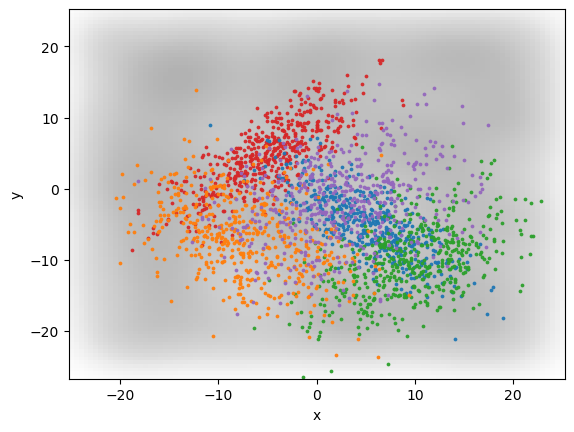

In [140]:
# Select background data (label 0)
X_bg_kde = df.loc[idx_bg, [x_col, y_col]].values.T

# Fit a Gaussian KDE to the background data
kde = gaussian_kde(X_bg_kde)

# Define a grid for plotting the KDE
x_min, x_max = df[x_col].min(), df[x_col].max()
y_min, y_max = df[y_col].min(), df[y_col].max()
X_grid, Y_grid = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))

# Evaluate the KDE on the grid
Z_grid = kde(np.vstack([X_grid.ravel(), Y_grid.ravel()])).reshape(X_grid.shape)

#make background sparse
plt.pcolormesh(X_grid, Y_grid, Z_grid, shading='auto', cmap='Greys', alpha=0.3)

for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5], alphas, colors, zorders): 
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)
    
#plt.xlim(-25000, 25000)
#plt.ylim(-25000, 25000)
plt.xlabel(x_col)#x_col,r'$v_\alpha$ ($km$ $s^{-1}$)'
plt.ylabel(y_col)#y_col,r'$v_\delta$ ($km$ $s^{-1}$)'
plt.show()


In [141]:
U, V, W = equatorial_UVW(
    ra,
    dec,
    pmra,
    pmdec,
    rv_calc,
    dist,
)
# Check if the transformation is correct
np.allclose(U, df.vx.values, atol=1e-1), np.allclose(V, df.vy.values, atol=1e-1), np.allclose(W, df.vz.values, atol=1e-1)
print(df)
df.to_csv('data.csv', index=False)


              x          y          z         vx         vy         vz  \
0     10.076523  23.828923   1.271328  16.008305 -23.316768 -15.961315   
1     -9.948279  16.381611  18.385124   0.634863 -22.825483  -4.159896   
2      1.538858  19.674659  19.431864 -20.230717   9.853980  23.202148   
3      0.335708  13.207280 -24.306521  17.777940 -13.850615 -22.623292   
4    -17.508774  -3.304260 -18.165993  -5.081839  24.970027 -16.613811   
...         ...        ...        ...        ...        ...        ...   
7495   9.232017  -0.215671  -4.918480   1.981756   1.917443  -0.006123   
7496  -1.214300  -8.867285  -3.624274   1.916790   1.757779   2.140521   
7497   7.142496   7.659698  -0.269926   1.755415   1.826643   1.854955   
7498   3.631802 -10.343597   0.138826   1.457403  -1.153782   2.000562   
7499  11.126758  11.918245  -3.513945   2.869074   2.740314   2.846448   

              ra        dec       dist        pmra       pmdec  \
0     297.241182  31.421642  25.903092    8.8

# Apply initial clustering of SigMa 

In [142]:
knn_list=[15, 20, 25, 30]
cluster_features = ['x', 'y','z'] #In which variables you want to cluster
sigma_kwargs = dict(
        cluster_features=cluster_features,
        nb_resampling=0,
        max_knn_density=int(np.max(knn_list)+1),
        beta=0.99,
        knn_initcluster_graph=35
    )

In [143]:
#make SigMA object
clusterer = SigMA(
            data=df,
            scale_factors=None, #needed for clustering in different spaces with scaling differences
            **sigma_kwargs
        )

In [144]:
#DO THE INITIAL CLUSTERS WITHOUT THE MERGING STEP OF RUN_SIGMA FUNCTION
clusterer.initialize_clustering(knn=20) #initialen cluster erstellt
clusterer.initialize_mode_neighbor_dict() #diese funktionen und mergeclusterer in parameters.py beschrieben
clusterer.resample_k_distances()# Compute k-distances for re-sampled data sets
leaf_labels = clusterer.leaf_labels_ 

Performing gradient ascend using a 20-NN density estimation.


In [145]:
np.unique(leaf_labels, return_counts = True) #the unique labels and how many in each leaf 

(array([   6,   12,   34,   91,  110,  113,  302,  316,  321,  325,  380,
         462,  469,  535,  536,  623,  703,  771,  874,  966,  991, 1011,
        1060, 1063, 1074, 1154, 1208, 1217, 1312, 1339, 1365, 1388, 1423,
        1538, 1654, 1655, 1656, 1677, 1693, 1695, 1720, 1856, 1863, 1905,
        1919, 1943, 2057, 2113, 2181, 2199, 2216, 2231, 2250, 2281, 2348,
        2382, 2390, 2439, 2455, 2543, 2683, 2719, 2749, 2839, 2846, 2920,
        2928, 2938, 2954, 2973, 3057, 3129, 3130, 3158, 3222, 3235, 3247,
        3316, 3380, 3466, 3523, 3588, 3628, 3633, 3651, 3705, 3726, 3736,
        3741, 3748, 3753, 3772, 3856, 3911, 3945, 3964, 3992, 3995, 4011,
        4114, 4117, 4122, 4232, 4286, 4374, 4389, 4403, 4472, 4482, 4591,
        4677, 4754, 4765, 4797, 4838, 4897, 4909, 4941, 4975, 4997, 5034,
        5109, 5116, 5204, 5314, 5406, 5495, 5513, 5515, 5576, 5676, 5693,
        5704, 5931, 6001, 6104, 6124, 6163, 6201, 6283, 6286, 6390, 6439,
        6500, 6578, 6627, 6682, 6695, 

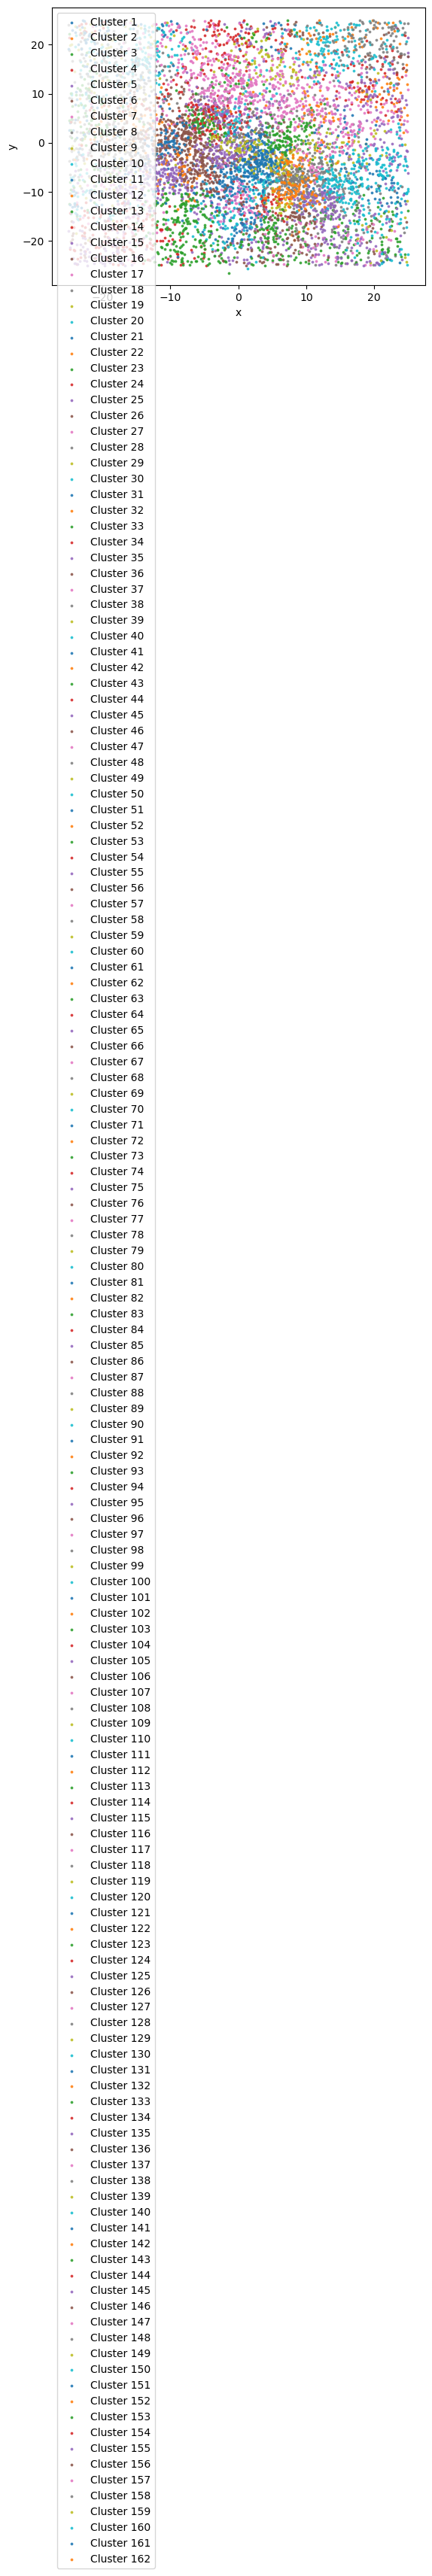

In [146]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
#x_col, y_col = 'pmra', 'pmdec'

for i, label in enumerate(np.unique(leaf_labels)):
    cluster_idx = np.where(leaf_labels == label)[0]  # Get the indices of the current cluster
    plt.scatter(df.loc[cluster_idx, x_col], df.loc[cluster_idx, y_col], 
                s=3, label=f'Cluster {i+1}', alpha=0.8)

# Add plot labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.legend()
plt.show()

# Create initial fine partition:  
Explore hierachy, look into the parameters class (merge_clusters). 
Use run_sigma with -infinity, get pvalues and sort them by icreasing size. 
run mergeclusters fct over and over again using different pvalues (np array distribution btw 0 and 1 zoom in o close to 0 and you get individual values. Choose alpha to be btw the pvalues. whats the center. 
vizualize what it looks like as fct of the alpha value.

In [147]:
#RUN SIGMA WITH P-VALUES
labels_s, pvalues = clusterer.run_sigma(alpha=-np.infty,knn=20,return_pvalues= True) 
sorted_pvalues = sorted(pvalues)

Text(0, 0.5, 'Density')

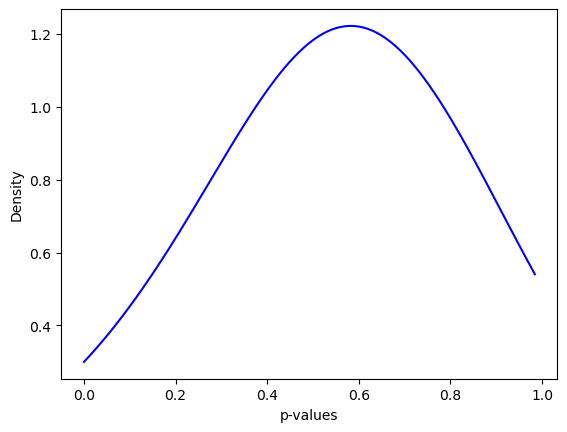

In [148]:
#PLOT DISTRIBUTION OF P-VALUES
mu = np.mean(sorted_pvalues)     
sigma = np.std(sorted_pvalues)    

# Compute the KDE
kde = gaussian_kde(sorted_pvalues, bw_method=1)

x_values = np.linspace(min(sorted_pvalues), max(sorted_pvalues), 500)
density = kde(x_values)

# Plot the normal distribution curve
plt.plot(x_values, density, color='blue')

plt.xlabel('p-values')
plt.ylabel('Density')

In [149]:
# zoom in in the region close to 0
###Ein kleinerer p-Wert bedeutet, dass die beobachteten Daten sehr unwahrscheinlich wären, wenn die Nullhypothese zutrifft###
lower_pvalues = [x for x in sorted_pvalues if x <= 0.2]
#make a list of alpha values that are the centers between all these pvalues
alpha_values = [(lower_pvalues[i] + lower_pvalues[i+1]) / 2 for i in range(len(lower_pvalues) - 1)]
print(lower_pvalues)
print(alpha_values) #Signifikanzniveau

[3.6903813338540203e-13, 0.00473720400941835, 0.038069017360313206, 0.05244010429125934, 0.05896403877120937, 0.06318361249111604, 0.0697715548199862, 0.07641339427703153, 0.11644347266689958, 0.11672178528559041, 0.11891883946902371, 0.12541935881222144, 0.12587506049762198, 0.15703177106080135]
[0.002368602004893694, 0.021403110684865778, 0.04525456082578627, 0.055702071531234354, 0.061073825631162704, 0.06647758365555112, 0.07309247454850887, 0.09642843347196556, 0.116582628976245, 0.11782031237730706, 0.12216909914062257, 0.1256472096549217, 0.14145341577921167]


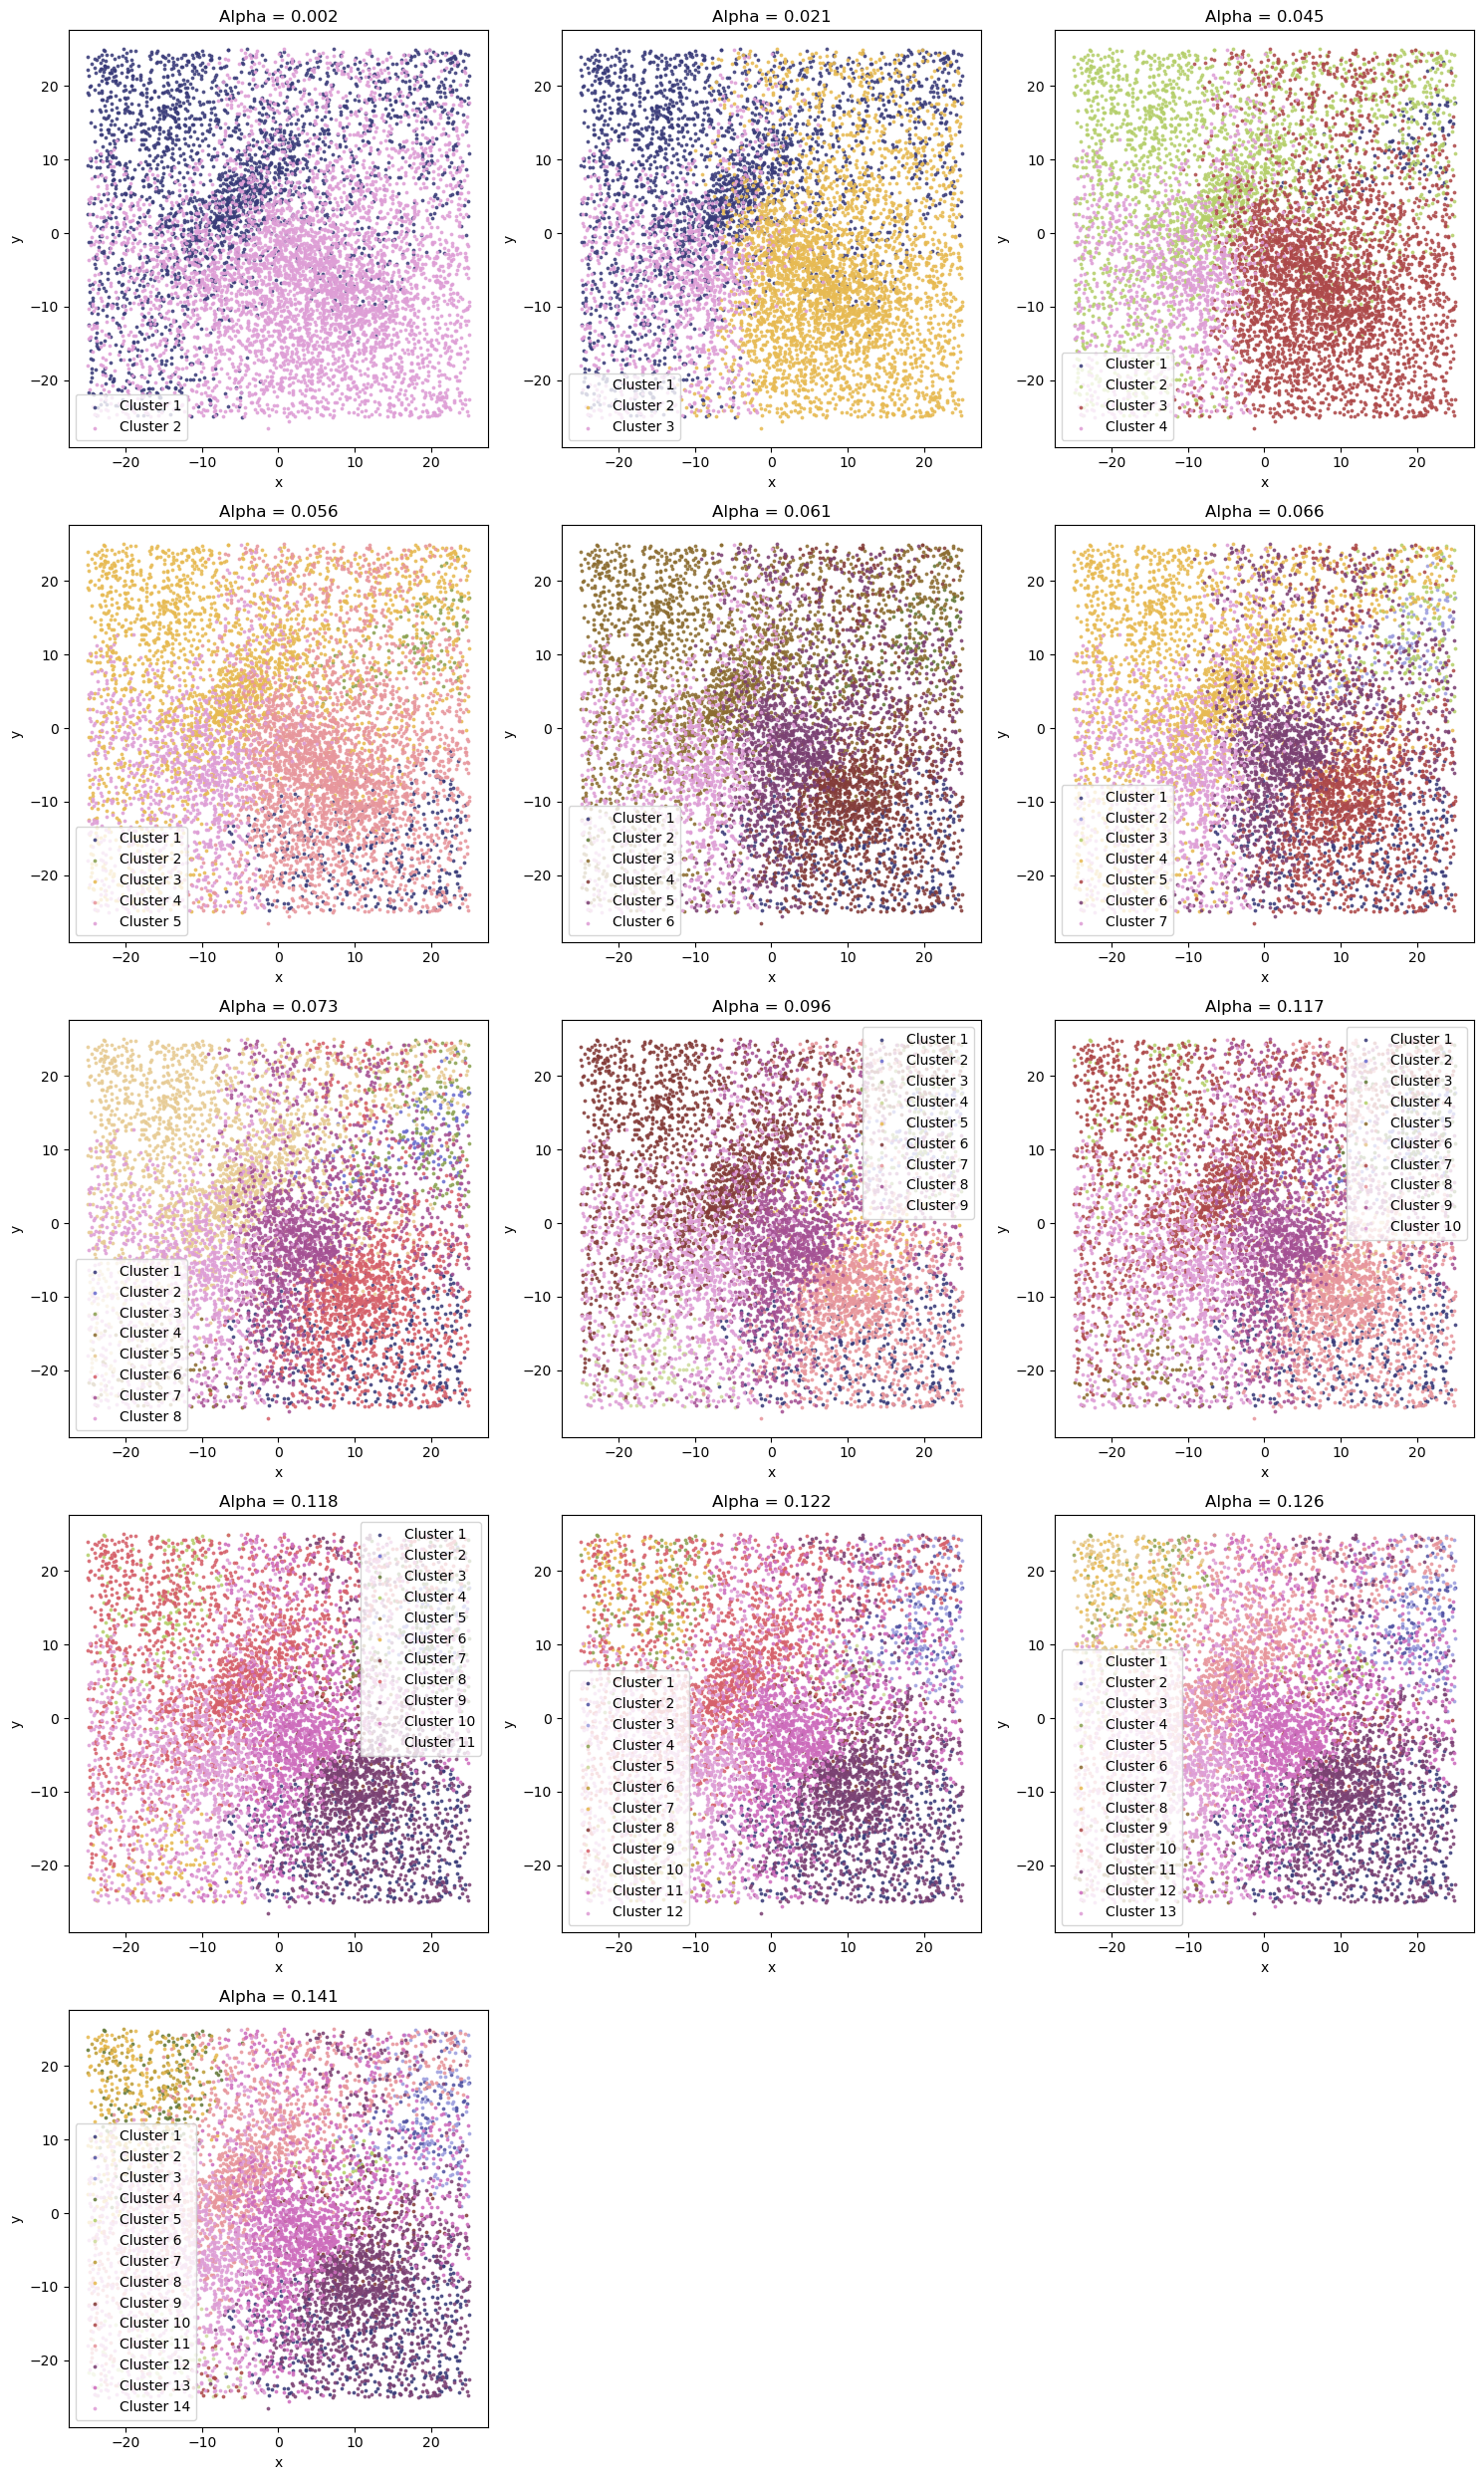

In [150]:
n_alpha = len(alpha_values)
cols = 3  # Set number of columns in the grid
rows = ceil(n_alpha / cols)  # number of rows needed

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Set the figure size
axs = axs.flatten()

# run the merge clustering for each alpha
for i, alpha in enumerate(alpha_values):
    merged_labels, merged_pvalues = clusterer.merge_clusters(knn=20, alpha=alpha)
    unique_labels = np.unique(merged_labels)
    #print(unique_labels)

    cmap = plt.get_cmap('tab20b', len(unique_labels)) 

    # Plot i-th subplot
    ax = axs[i]
    for j, label in enumerate(unique_labels):
        cluster_idx = np.where(merged_labels == label)[0]  # Get indices of the current cluster
        ax.scatter(df.loc[cluster_idx, x_col], df.loc[cluster_idx, y_col],
                   s=3, label=f'Cluster {j+1}', alpha=0.8, color=cmap(j))  

    ax.set_title(f'Alpha = {alpha:.3f}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()

for ax in axs[n_alpha:]:
    ax.axis('off')
plt.tight_layout()
plt.show()


#branch luisa - softmax optimized - lass auf deinem datenset laufen, berechne G (est Vropt) -> berechne dist Vopt 
# -> bau triag matrix mit indices len(X) -> nxn matrix mit opt distances 
# pi opt ist clustering ergebnis 
# K=6 (sie hat 6 cluster )  KxN matrix
#get clusters fct. entfernt spalten mit nur 0 
#plot ergebnis wie bei ihr in 36 
#ursprl. 5 cluster werden getrennt plus 6. cluster mit nur noise 
#B) lass nich auf ganzes laufen aber auf die sets wie hier  - berechne G bei zb in 2 gesplitteten G1 G2 (man muss mit ind spielen)
# lass softmax wieder laufen - wie gut clustering ergebnis ? nmi ?
#labels_softmax_opt für G1 und G2 -> merge cluster result von G1 G2 
#pass auf mit indizes 01 eg 012 -> 234
#nmi - wie ist kurve - wird es besser - trenn mehr auf (komplett seperate zellen betrachten aber evt. 1 cluster komm in mehreeren zellen vor)
#annahme nmi nimmt ab

#iphd 


# How are real labels represented in unique labels  


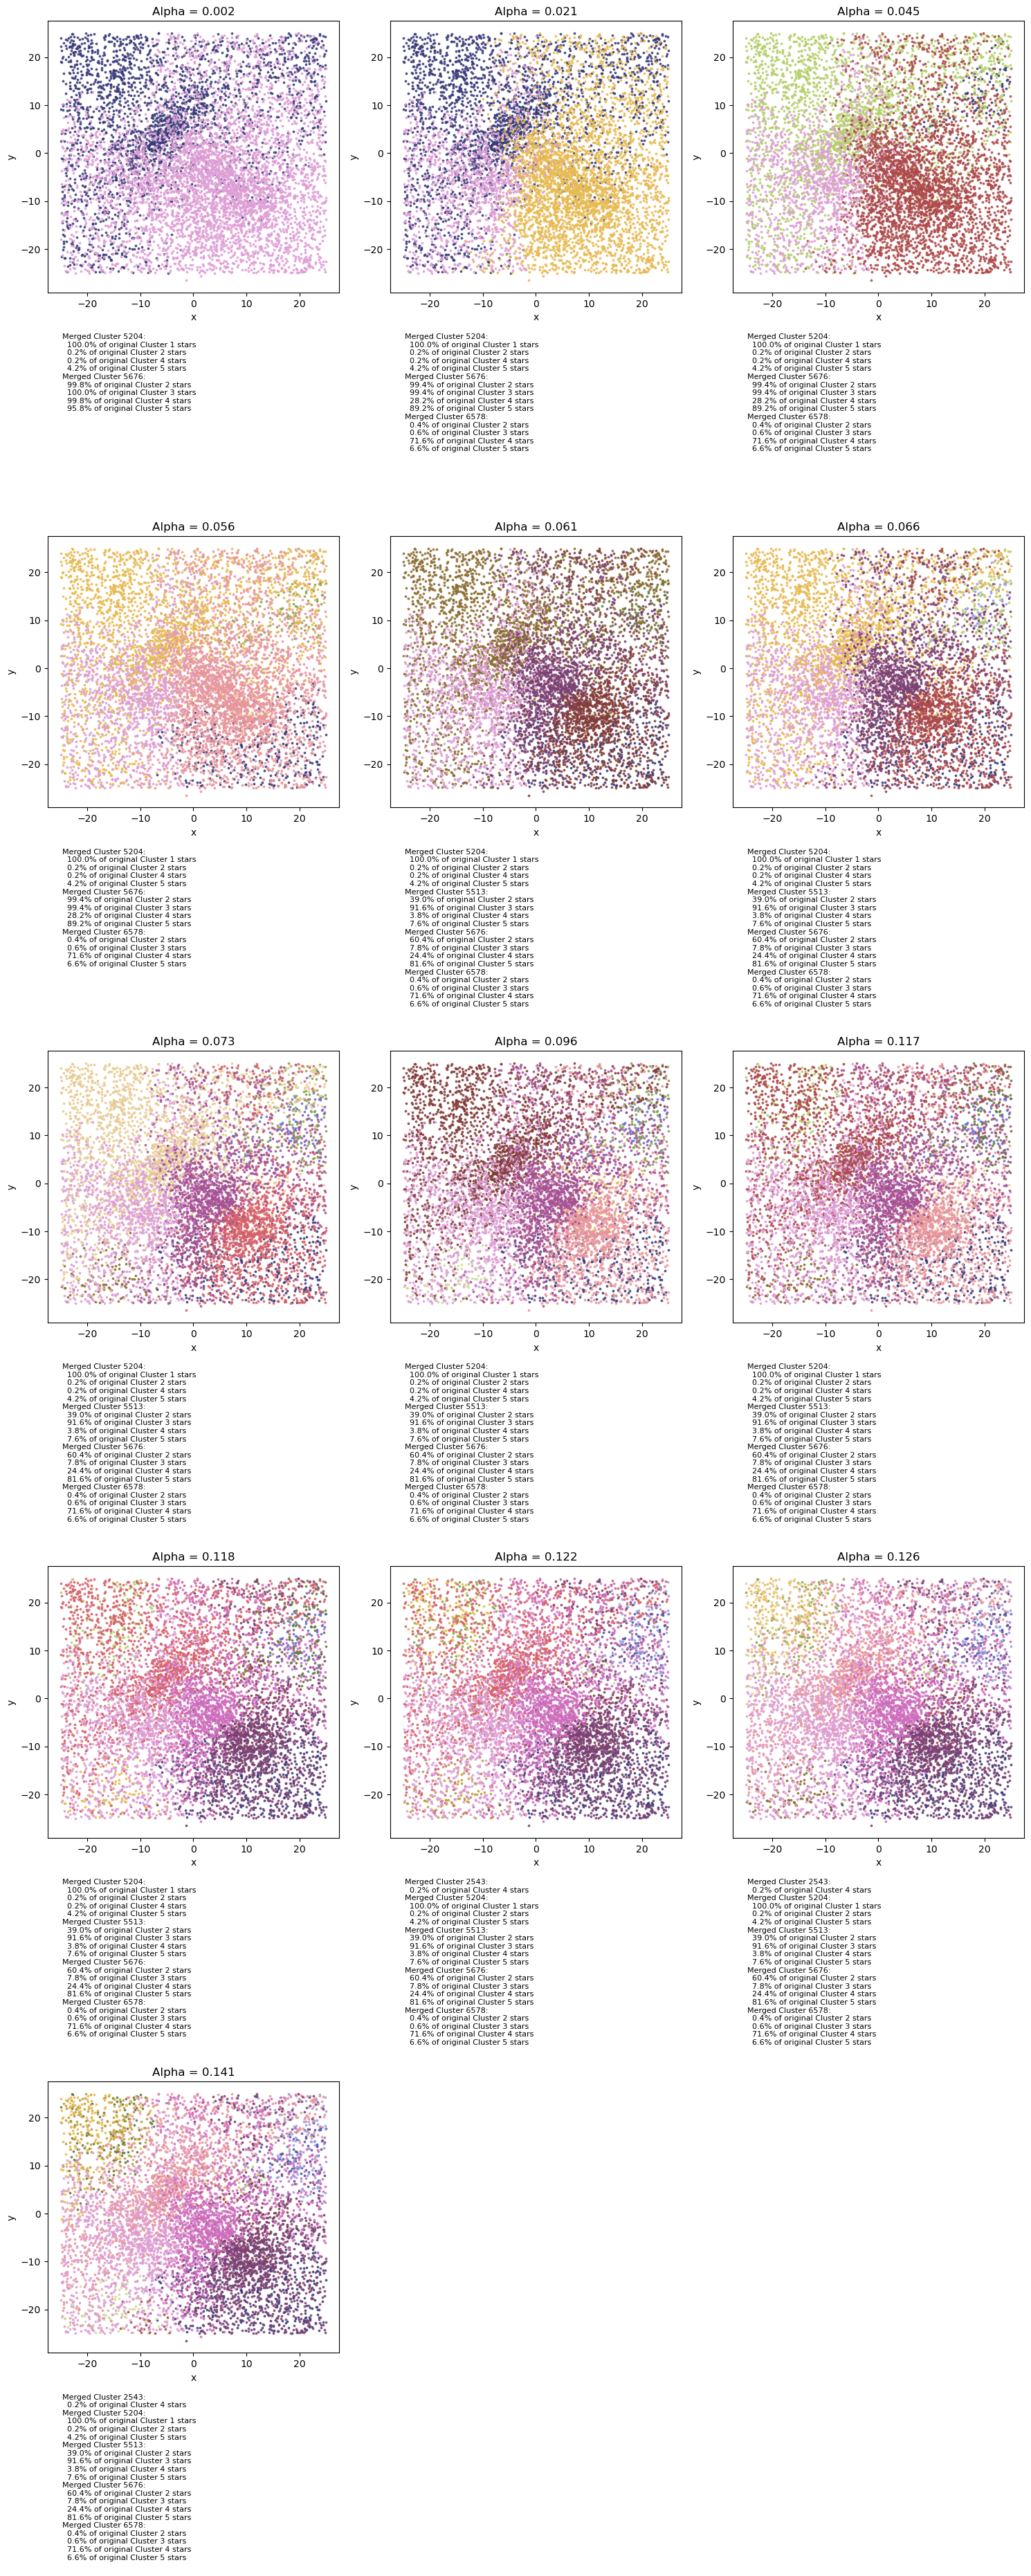

In [151]:
n_alpha = len(alpha_values)
cols = 3 
rows = ceil(n_alpha / cols)  # number of rows needed

fig, axs = plt.subplots(rows, cols, figsize=(15, 7.5 * rows))  
axs = axs.flatten()

# original clusters as dictionary
original_clusters = {
    1: idx_cluster_1, 
    2: idx_cluster_2, 
    3: idx_cluster_3, 
    4: idx_cluster_4, 
    5: idx_cluster_5
}

# Run the merge clustering for each alpha
for i, alpha in enumerate(alpha_values):
    merged_labels, merged_pvalues = clusterer.merge_clusters(knn=20, alpha=alpha)
    unique_labels = np.unique(merged_labels)
    cmap = plt.get_cmap('tab20b', len(unique_labels)) 
    
    # Initialize a dictionary to store cluster distribution for display
    cluster_distribution = {}

    # Plot i-th subplot
    ax = axs[i]
    for j, label in enumerate(unique_labels):
        cluster_idx = np.where(merged_labels == label)[0]  # Get indices of the current cluster
        ax.scatter(df.loc[cluster_idx, x_col], df.loc[cluster_idx, y_col],
                   s=3, label=f'Cluster {j+1}', alpha=0.8, color=cmap(j))

        # Calculate distribution of original clusters within this merged cluster
        cluster_distribution[label] = {}
        for original_label, original_indices in original_clusters.items():
            common_indices = np.intersect1d(cluster_idx, original_indices)
            percentage = len(common_indices) / len(original_indices) * 100 if len(original_indices) > 0 else 0
            if percentage > 0:
                cluster_distribution[label][original_label] = percentage

    merge_info = ""
    for merged_label, distribution in cluster_distribution.items():
        if distribution:  # Only add if there's a non-zero percentage from any original clusters
            merge_info += f"Merged Cluster {merged_label}:\n"
            for original_label, percentage in distribution.items():
                merge_info += f"  {percentage:.1f}% of original Cluster {original_label} stars\n"
    
    ax.set_title(f'Alpha = {alpha:.3f}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    #ax.legend()
    ax.text(0.05, -0.15, merge_info, transform=ax.transAxes, fontsize=8, verticalalignment='top', wrap=True)

# Hide any unused subplots
for ax in axs[n_alpha:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


# NMI plot (normalized_mutual_info_score)

In [159]:
print(merged_labels)

[5204 3316 5204 ... 5676 5676 5676]


TypeError: float() argument must be a string or a real number, not 'ellipsis'

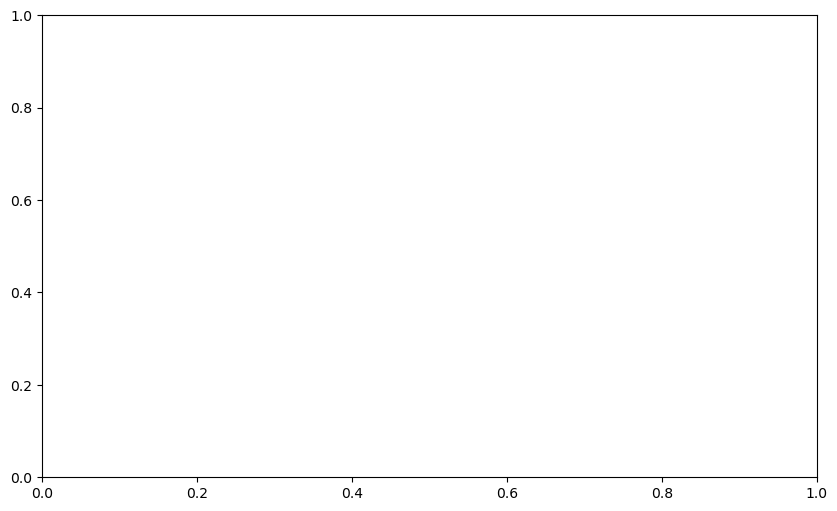

In [155]:
#ignore all noise -1 
#nmi sklearn für jedes splitting (alle labels die nicht -1 sind bei lab_t)
#nmi plot all merged vs nmi -> alpha ausrechnen - kann auch alpha auf x (nicht equidistant) -> berechne opt alpha 

true_labels = labels
pred_labels = merged_labels # Replace with predicted labels from SigMA (includes -1 for noise)

# Calculate NMI for each alpha value
nmi_scores = []
optimal_alpha_index = -1
max_nmi = -1

for alpha in alpha_values:
    # Extract true labels ignoring noise
    true_mask = true_labels != -1
    filtered_true_labels = true_labels[true_mask]
    filtered_pred_labels = pred_labels[true_mask]

    # Calculate NMI only if both true and predicted labels have at least one entry
    if len(filtered_true_labels) > 0 and len(filtered_pred_labels) > 0:
        nmi = normalized_mutual_info_score(filtered_true_labels, filtered_pred_labels)
        nmi_scores.append(nmi)

        # Check for optimal alpha
        if nmi > max_nmi:
            max_nmi = nmi
            optimal_alpha_index = len(nmi_scores) - 1  # Index of the best NMI score

# Plotting NMI against alpha values
plt.figure(figsize=(10, 6))
plt.plot(alpha_values[:len(nmi_scores)], nmi_scores, marker='o')
plt.title('Normalized Mutual Information (NMI) vs. Alpha Values')
plt.xlabel('Alpha Values')
plt.ylabel('NMI Score')
plt.axvline(alpha_values[optimal_alpha_index], color='r', linestyle='--', label=f'Optimal Alpha: {alpha_values[optimal_alpha_index]:.3f}')
plt.legend()
plt.grid()
plt.show()

# Output the optimal alpha
optimal_alpha = alpha_values[optimal_alpha_index]
print(f'Optimal Alpha: {optimal_alpha:.3f} with NMI: {max_nmi:.3f}')

In [156]:
print(nmi_scores)

[0.5850248888359957]
